# Surrogate models training and validation

## Importation

In [52]:
#from ml.bayesian_opt import BO
import tensorflow as tf
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
from sklearn.model_selection import train_test_split
from ml.neural_net import NN, NN_co2
from ml.neural_net import hyp_param_opt
from ml.validate import evaluate_predictions
from ml.validate import plot_true_vs_predicted, plot_model1_vs_model2, plot_loss
from ml.opt import opt, opt_gp, opt_ismo
from util.time import measure_and_plot_time
from util.normalization import minmax_normalize

import matplotlib.pyplot as plt

import os
import warnings
warnings.filterwarnings("ignore")

# Model for Elastic Modulus from Recipe

In [82]:
########################################################################################
#
#                   LOAD DATA
#
########################################################################################
########################################################################################
#
#                   LOAD DATA
#
########################################################################################
#importation of data for NN
file_path = '/mnt/disk1/projects/Cement/02-Software_and_Models/Models/InputData/'
model_path = '/mnt/disk1/projects/Cement/02-Software_and_Models/Models/Output/Models/'
name = '2500'
X = pd.read_csv(file_path+ 'recipe_data_LHS_'+name+'_new.csv',  index_col=[0])
y = pd.read_csv(file_path+ 'elastic_moduli_'+name+'.csv')

y = y[['K','G']]
y

K          G
0     18.617533   8.436368
1     59.133080  21.555046
2     21.063708   8.884028
3     22.942406   9.903171
4     22.115643   9.530224
...         ...        ...
2379  50.366058  18.567644
2380  17.446178   8.364303
2381  63.250487  23.284372
2382  16.140162   7.866115
2383  19.057862   8.282863

[2384 rows x 2 columns]

In [83]:
X.keys()

Index(['C3S', 'C2S', 'C3A', 'C4AF', 'CSH2', 'wc', 'RH', 'T', 'fineness',
       'limestone', 'silica_fume', 'GGBFS', 'fly_ash', 'calcined_clay',
       'wc_ratio'],
      dtype='object')

In [84]:
X = X[['C3S', 'C2S', 'C3A', 'C4AF', 'CSH2',
       'limestone', 'silica_fume', 'GGBFS', 'fly_ash', 'calcined_clay',
       'wc_ratio']]

In [85]:
# Gaussian process
#train_input, test_input, train_elastic, test_elastic = train_test_split(X, y, test_size=0.2, random_state=42)
train_input = X
train_elastic = y



#train_input_gp, test_input_gp, train_elastic_gp, test_elastic_gp = train_test_split(X, y, test_size=0.2, random_state=42)
# suppress low values of aq_gen for a nice relative error
#test_input_gp = test_input_gp[test_output_gp['aq_gen'] > 1e-4]
#test_output_gp = test_output_gp[test_output_gp['aq_gen'] > 1e-4]

In [86]:
#test_input.to_csv(file_path+'/test_data_recipe_189.csv')
#test_elastic.to_csv(file_path+'/test_data_elastic_189.csv')

In [87]:
test_input = pd.read_csv(file_path+'/test_data_recipe_189.csv')
test_elastic= pd.read_csv(file_path+'/test_data_elastic_189.csv')

In [88]:
train_input = train_input.reset_index(drop = True)
train_elastic = train_elastic.reset_index(drop = True)

In [89]:
test_input = test_input.drop(['Unnamed: 0'], axis = 1)
test_elastic = test_elastic.drop(['Unnamed: 0'], axis = 1)


In [90]:
########################################################################################
#
#                    NEURAL NETWORK
#
########################################################################################

# train the neural network
elasticity_NN, elasticity_history = NN(train_input, train_elastic, test_input, test_elastic)
elasticity_NN.save(model_path+'elasticity_NN_1000.h5')
# load the already trained neural network
#model_path = 'model/elasticity_2^15.h5'
#elasticity_NN = load_model(model_path, compile = False)

Constructing the network
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 50)                600       
                                                                 
 dense_34 (Dense)            (None, 50)                2550      
                                                                 
 dense_35 (Dense)            (None, 50)                2550      
                                                                 
 dense_36 (Dense)            (None, 50)                2550      
                                                                 
 dense_37 (Dense)            (None, 50)                2550      
                                                                 
 dense_38 (Dense)            (None, 50)                2550      
                                                                 
 dense_39 (Dense)            

In [91]:

########################################################################################
#
#                    Validation of the neural net
#
########################################################################################
# Print the loss per epoch
#plot_loss(hydration_history, 'Hydration', train_input.shape[0])

# Evaluation of performance of the network
predicted_values = elasticity_NN(test_input.to_numpy()).numpy()
model_perf = evaluate_predictions(test_elastic, predicted_values)
model_perf.to_csv(model_path +'model_perf/elasticity_NN_'+str(name)+'.csv')
print(model_perf)
# Plot the true vs predicted plot


   RelativeError  MeanSquaredError  CoefficientOfDetermination
0       0.047788          4.822645                    0.971818
1       0.040914          0.540158                    0.969412


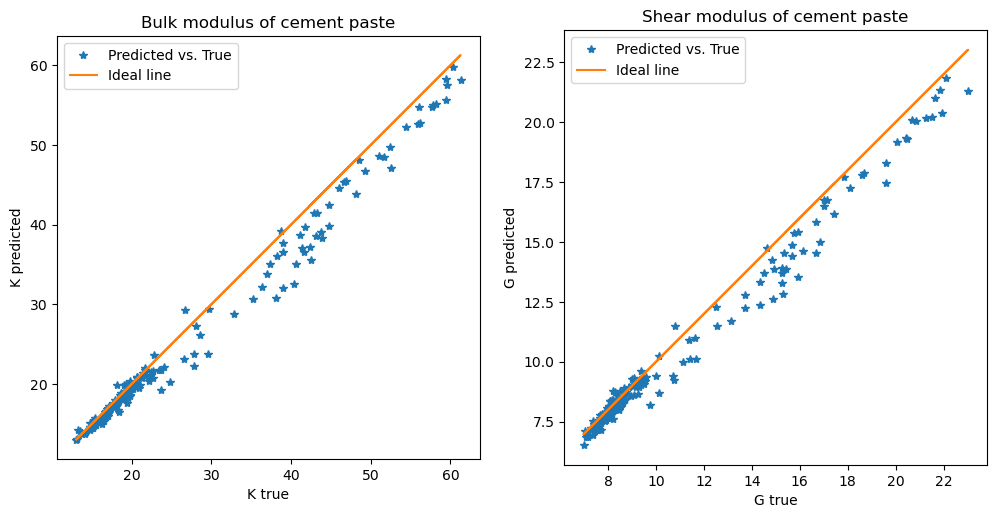

In [92]:
predicted_values = pd.DataFrame(predicted_values, columns = ['K','G'])
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 10))  # 1 row, 2 columns, and optional figure size

# First subplot for Bulk modulus
axs[0].plot(test_elastic['K'], predicted_values['K'], '*', label='Predicted vs. True')
axs[0].plot(test_elastic['K'], test_elastic['K'], label='Ideal line')  # Ideal line where predicted = true
axs[0].set_xlabel('K true')
axs[0].set_ylabel('K predicted')
axs[0].set_title('Bulk modulus of cement paste')
axs[0].legend()
axs[0].set_aspect('equal') 
# Second subplot for Shear modulus
axs[1].plot(test_elastic['G'], predicted_values['G'], '*', label='Predicted vs. True')
axs[1].plot(test_elastic['G'], test_elastic['G'], label='Ideal line')  # Ideal line where predicted = true
axs[1].set_xlabel('G true')
axs[1].set_ylabel('G predicted')
axs[1].set_title('Shear modulus of cement paste')
axs[1].legend()
axs[1].set_aspect('equal')  # Equal scaling

# Adjust layout
#plt.tight_layout()

# Show plot
plt.savefig(model_path +'model_perf/elasticity_NN_'+str(name)+'.png')
plt.show()


In [93]:
########################################################################################
#
#                    GAUSSIAN PROCESS
#
########################################################################################
kernel = 1**2 * Matern(length_scale=1, nu=1.5)

gpg = GaussianProcessRegressor(kernel).fit(train_input, train_elastic)
print('=====================================================')
print('The score for the Gaussian Process for hydration is: ', gpg.score(train_input, train_elastic))
print('The mean square error on the test set is: ', np.mean((gpg.predict(test_input)-test_elastic)**2))


The score for the Gaussian Process for hydration is:  1.0
The mean square error on the test set is:  25.693684091211225


In [94]:
########################################################################################
#
#                    Validation of the GP
#
########################################################################################
#Evaluation of the GP
predicted_values_gp = gpg.predict(test_input)
model_perf_gp = evaluate_predictions(test_elastic, predicted_values_gp)
model_perf.to_csv(model_path +'model_perf/elasticity_GP_'+str(name)+'.csv')

model_perf_gp

RelativeError  MeanSquaredError  CoefficientOfDetermination
0       0.257039         47.079226                     0.72488
1       0.172065          4.308142                     0.75604

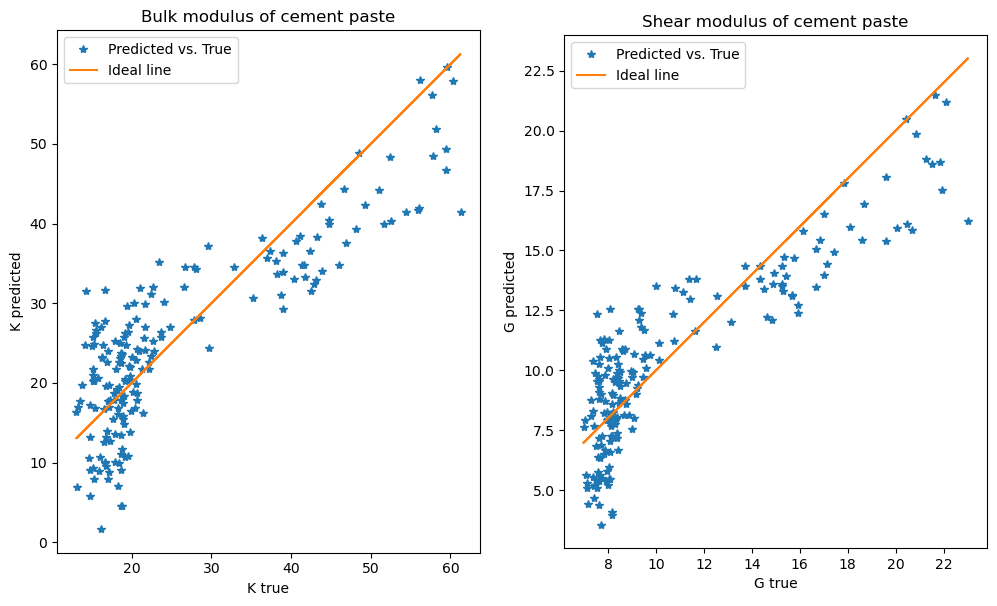

In [95]:
predicted_values_gp = pd.DataFrame(predicted_values_gp, columns = ['K','G'])

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 10))  # 1 row, 2 columns, and optional figure size

# First subplot for Bulk modulus
axs[0].plot(test_elastic['K'], predicted_values_gp['K'], '*', label='Predicted vs. True')
axs[0].plot(test_elastic['K'], test_elastic['K'], label='Ideal line')  # Ideal line where predicted = true
axs[0].set_xlabel('K true')
axs[0].set_ylabel('K predicted')
axs[0].set_title('Bulk modulus of cement paste')
axs[0].legend()
axs[0].set_aspect('equal') 
# Second subplot for Shear modulus
axs[1].plot(test_elastic['G'], predicted_values_gp['G'], '*', label='Predicted vs. True')
axs[1].plot(test_elastic['G'], test_elastic['G'], label='Ideal line')  # Ideal line where predicted = true
axs[1].set_xlabel('G true')
axs[1].set_ylabel('G predicted')
axs[1].set_title('Shear modulus of cement paste')
axs[1].legend()
axs[1].set_aspect('equal')  # Equal scaling

# Adjust layout
#plt.tight_layout()

plt.savefig(model_path +'model_perf/elasticity_GP_'+str(name)+'.png')

# Show plot
plt.show()



In [97]:
# Train all neural networks:

def neural_net_training(nr_samples):
    name = str(nr_samples)
    file_path = '/mnt/disk1/projects/Cement/02-Software_and_Models/Models/InputData/'
    model_path = '/mnt/disk1/projects/Cement/02-Software_and_Models/Models/Output/Models/'

    X = pd.read_csv(file_path+ 'recipe_data_LHS_'+name+'_new.csv',  index_col=[0])
    y = pd.read_csv(file_path+ 'elastic_moduli_'+name+'.csv')
    
    y = y[['K','G']]
    X = X[['C3S', 'C2S', 'C3A', 'C4AF', 'CSH2',
       'limestone', 'silica_fume', 'GGBFS', 'fly_ash', 'calcined_clay',
       'wc_ratio']]
    train_input = X
    train_elastic = y
    test_input = pd.read_csv(file_path+'/test_data_recipe_189.csv')
    test_elastic= pd.read_csv(file_path+'/test_data_elastic_189.csv')
    train_input = train_input.reset_index(drop = True)
    train_elastic = train_elastic.reset_index(drop = True)

    test_input = test_input.drop(['Unnamed: 0'], axis = 1)
    test_elastic = test_elastic.drop(['Unnamed: 0'], axis = 1)
    elasticity_NN, elasticity_history = NN(train_input, train_elastic, test_input, test_elastic)
    elasticity_NN.save(model_path+'elasticity_NN_'+name+'.h5')
    ########################################################################################
    #
    #                    Validation of the neural net
    #
    ########################################################################################
    # Print the loss per epoch
    #plot_loss(hydration_history, 'Hydration', train_input.shape[0])
    
    # Evaluation of performance of the network
    predicted_values = elasticity_NN(test_input.to_numpy()).numpy()
    model_perf = evaluate_predictions(test_elastic, predicted_values)
    model_perf.to_csv(model_path +'model_perf/elasticity_NN_'+name+'.csv')
    print(model_perf)
    # Plot the true vs predicted plot
    predicted_values = pd.DataFrame(predicted_values, columns = ['K','G'])
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 10))  # 1 row, 2 columns, and optional figure size
    
    # First subplot for Bulk modulus
    axs[0].plot(test_elastic['K'], predicted_values['K'], '*', label='Predicted vs. True')
    axs[0].plot(test_elastic['K'], test_elastic['K'], label='Ideal line')  # Ideal line where predicted = true
    axs[0].set_xlabel('K true')
    axs[0].set_ylabel('K predicted')
    axs[0].set_title('Bulk modulus of cement paste')
    axs[0].legend()
    axs[0].set_aspect('equal') 
    # Second subplot for Shear modulus
    axs[1].plot(test_elastic['G'], predicted_values['G'], '*', label='Predicted vs. True')
    axs[1].plot(test_elastic['G'], test_elastic['G'], label='Ideal line')  # Ideal line where predicted = true
    axs[1].set_xlabel('G true')
    axs[1].set_ylabel('G predicted')
    axs[1].set_title('Shear modulus of cement paste')
    axs[1].legend()
    axs[1].set_aspect('equal')  # Equal scaling
    
    # Adjust layout
    #plt.tight_layout()
    
    # Show plot
    plt.savefig(model_path +'model_perf/elasticity_NN_'+name+'.png')
    plt.show()


Constructing the network
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 50)                600       
                                                                 
 dense_67 (Dense)            (None, 50)                2550      
                                                                 
 dense_68 (Dense)            (None, 50)                2550      
                                                                 
 dense_69 (Dense)            (None, 50)                2550      
                                                                 
 dense_70 (Dense)            (None, 50)                2550      
                                                                 
 dense_71 (Dense)            (None, 50)                2550      
                                                                 
 dense_72 (Dense)            

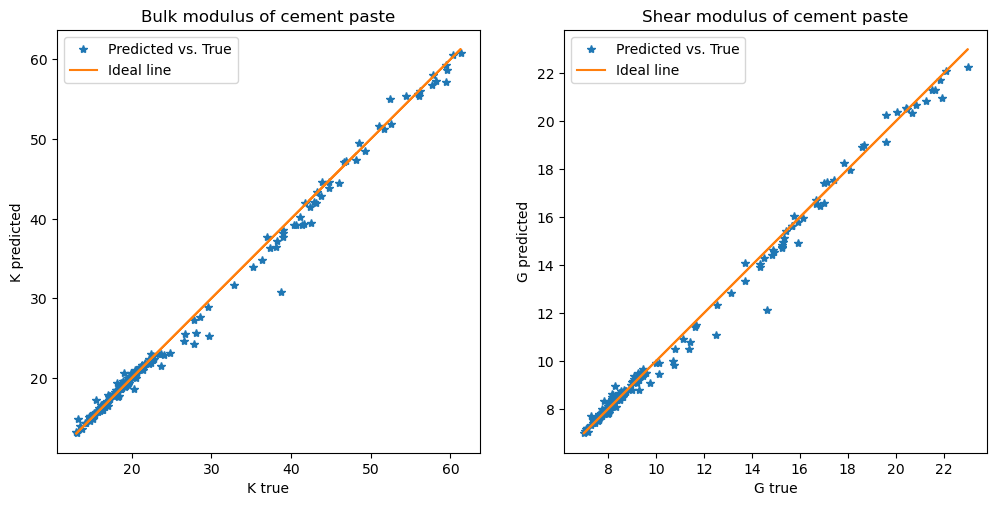

Constructing the network
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            (None, 50)                600       
                                                                 
 dense_78 (Dense)            (None, 50)                2550      
                                                                 
 dense_79 (Dense)            (None, 50)                2550      
                                                                 
 dense_80 (Dense)            (None, 50)                2550      
                                                                 
 dense_81 (Dense)            (None, 50)                2550      
                                                                 
 dense_82 (Dense)            (None, 50)                2550      
                                                                 
 dense_83 (Dense)            

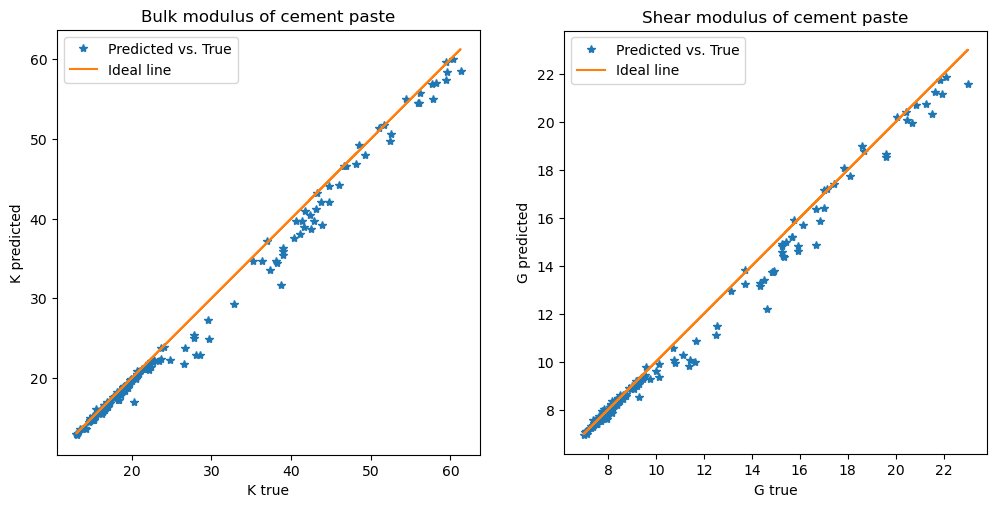

Constructing the network
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 50)                600       
                                                                 
 dense_89 (Dense)            (None, 50)                2550      
                                                                 
 dense_90 (Dense)            (None, 50)                2550      
                                                                 
 dense_91 (Dense)            (None, 50)                2550      
                                                                 
 dense_92 (Dense)            (None, 50)                2550      
                                                                 
 dense_93 (Dense)            (None, 50)                2550      
                                                                 
 dense_94 (Dense)            

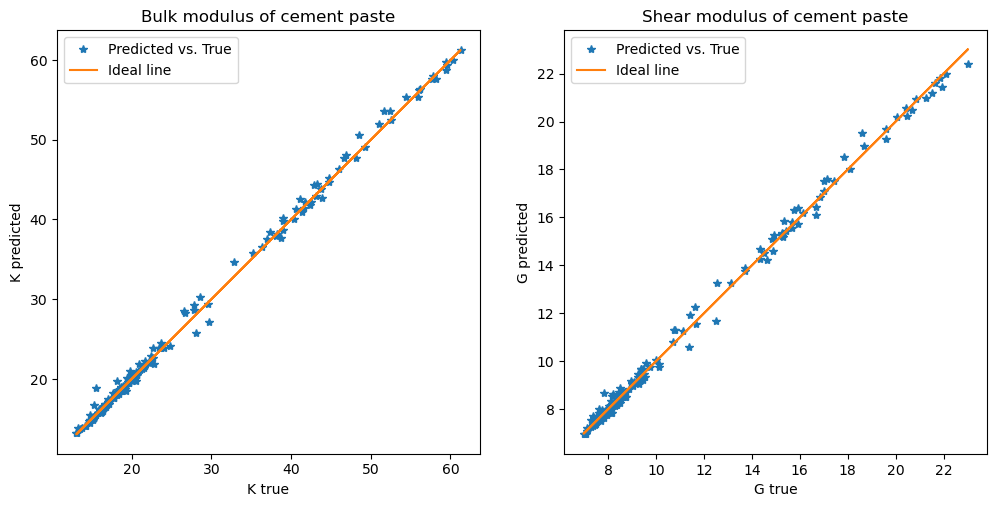

Constructing the network
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_99 (Dense)            (None, 50)                600       
                                                                 
 dense_100 (Dense)           (None, 50)                2550      
                                                                 
 dense_101 (Dense)           (None, 50)                2550      
                                                                 
 dense_102 (Dense)           (None, 50)                2550      
                                                                 
 dense_103 (Dense)           (None, 50)                2550      
                                                                 
 dense_104 (Dense)           (None, 50)                2550      
                                                                 
 dense_105 (Dense)           

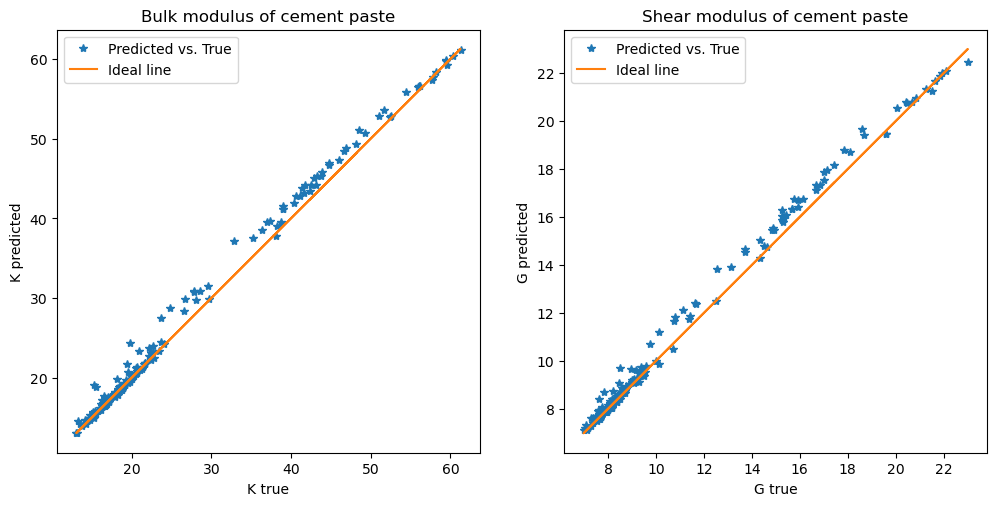

Constructing the network
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_110 (Dense)           (None, 50)                600       
                                                                 
 dense_111 (Dense)           (None, 50)                2550      
                                                                 
 dense_112 (Dense)           (None, 50)                2550      
                                                                 
 dense_113 (Dense)           (None, 50)                2550      
                                                                 
 dense_114 (Dense)           (None, 50)                2550      
                                                                 
 dense_115 (Dense)           (None, 50)                2550      
                                                                 
 dense_116 (Dense)          

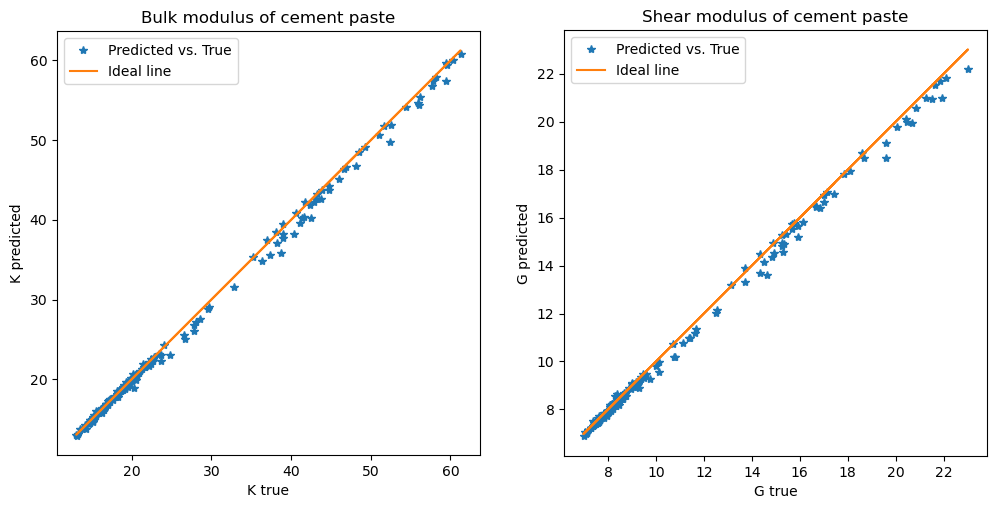

Constructing the network
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_121 (Dense)           (None, 50)                600       
                                                                 
 dense_122 (Dense)           (None, 50)                2550      
                                                                 
 dense_123 (Dense)           (None, 50)                2550      
                                                                 
 dense_124 (Dense)           (None, 50)                2550      
                                                                 
 dense_125 (Dense)           (None, 50)                2550      
                                                                 
 dense_126 (Dense)           (None, 50)                2550      
                                                                 
 dense_127 (Dense)          

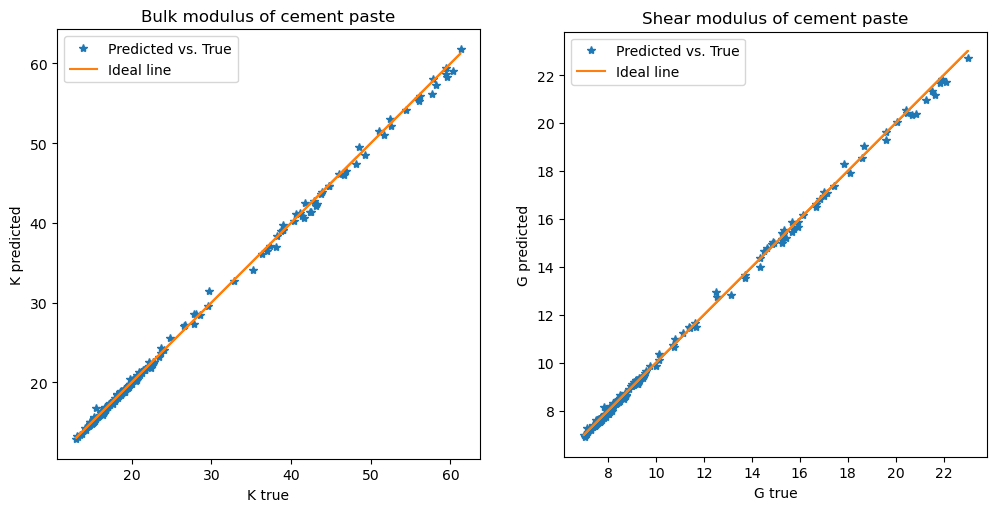

In [100]:
namelist = [5000, 7500,10000,12500,15000,17500]

for nr in namelist:
    neural_net_training(nr)

In [101]:
X

C3S        C2S        C3A       C4AF      CSH2  limestone  \
0     57.759534  23.535395   0.577458  14.127612  4.000000   5.640195   
1     69.804651  16.620560   5.151376   4.423414  4.000000  13.078182   
2     70.530976  12.161473   7.697921   5.609630  4.000000  15.254443   
3     59.915648  21.038511   8.003623   7.042218  4.000000  17.214484   
4     49.277774  32.147100   5.015461   9.541277  4.018388   2.377562   
...         ...        ...        ...        ...       ...        ...   
2379  56.065586  14.973678  12.124804  12.835933  4.000000   9.443169   
2380  69.332523  17.299519   6.433775   2.934183  4.000000   6.218185   
2381  74.653186  18.248750   0.255812   2.842252  4.000000  14.568705   
2382  68.012854  13.934451   5.276540   8.776155  4.000000   2.987946   
2383  51.712821  20.992550  10.221857  13.072772  4.000000   2.735922   

      silica_fume      GGBFS    fly_ash  calcined_clay  wc_ratio  
0        2.484955   9.900995  20.214206       7.343695  0.572945  
1        7.445782  31.891107  30.228413       0.355157  0.408889  
2        3.570133  22.133387   7.081840      31.336437  0.493795  
3        5.303480   7.945340   7.374823      20.248623  0.353365  
4        9.794450  12.749963  20.150445      18.786043  0.433307  
...           ...        ...        ...            ...       ...  
2379     1.663355  15.423068  34.277295      12.669625  0.360233  
2380     5.679876  20.245376  26.308461       4.140205  0.557165  
2381     5.073597  32.170070  34.543236       0.478878  0.345697  
2382     5.997427  20.316890  17.708088       2.239385  0.655840  
2383     8.030414   3.380232  28.291752      16.133042  0.574853  

[2384 rows x 11 columns]